<a href="https://colab.research.google.com/github/kostkalab/mol-evol_notebooks/blob/main/lecture_mol_evol_04_05_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-neutral substitutioun rates

Here we will use methods discuessed in the lecture (phastCons, phyloP) to annotate deep (100-way) alignments.


### Install software

In [ ]:
#- install rphast
devtools::install_github("CshlSiepelLab/RPHAST")
library(rphast)

In [ ]:
#- install GenomicRanges etc., takes a while (~)
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("GenomicRanges")
library(GenomicRanges)

In [ ]:
#- biomaRt and Gviz for annotation and visualization
BiocManager::install("biomaRt")
BiocManager::install("Gviz")

### Download alignment data and neutral model



In [ ]:
#- download prepared maf fikle
url <- 'https://github.com/kostkalab/mol-evol_notebooks/blob/main/reg.maf.gz?raw=true'
tfle_name1 <- paste0(tempfile(),'.maf.gz')
download.file(url, tfle_name1)
system( paste0( 'gunzip ', tfle_name1))
tfle_name2 <-  tfle_name1 |> stringr::str_remove('\\.gz')

In [ ]:
#- take a look
system(paste0( 'head ', tfle_name2), intern = TRUE)

[1] "##maf version=1"                                                       
 [2] "a score=457035.0"                                                      
 [3] "s hg38.chr13                    31933897    10 + 114364328 TTGCAGAATT "
 [4] "s panTro4.chr13                 31567707    10 + 115123233 TTGCAGAATT "
 [5] "i panTro4.chr13                                            C 0 C 0    "
 [6] "s gorGor3.chr13                 13789293    10 +  97499607 gtgcagaatt "
 [7] "i gorGor3.chr13                                            C 0 C 0    "
 [8] "s ponAbe2.chr13                 31457778    10 + 117095149 ttgcagaatt "
 [9] "i ponAbe2.chr13                                            C 0 C 0    "
[10] "s nomLeu3.chr9                 110739758    10 - 118206036 ttgcagaatt "

In [ ]:
#- read in alignment
msa <- read.msa(tfle_name2)
msa

msa object with 100 sequences and 1391488 columns, stored in R
$names
  [1] "hg38"       "panTro4"    "gorGor3"    "ponAbe2"    "nomLeu3"   
  [6] "rheMac3"    "macFas5"    "papAnu2"    "chlSab2"    "tupChi1"   
 [11] "speTri2"    "criGri1"    "mesAur1"    "hetGla2"    "cavPor3"   
 [16] "chiLan1"    "octDeg1"    "oryCun2"    "susScr3"    "vicPac2"   
 [21] "camFer1"    "turTru2"    "orcOrc1"    "panHod1"    "bosTau8"   
 [26] "oviAri3"    "capHir1"    "equCab2"    "cerSim1"    "felCat8"   
 [31] "canFam3"    "ailMel1"    "odoRosDiv1" "lepWed1"    "pteAle1"   
 [36] "pteVam1"    "eriEur2"    "sorAra2"    "loxAfr3"    "triMan1"   
 [41] "dasNov3"    "micOch1"    "ochPri3"    "oryAfe1"    "calJac3"   
 [46] "saiBol1"    "mm10"       "jacJac1"    "rn6"        "eptFus1"   
 [51] "myoDav1"    "myoLuc2"    "sarHar1"    "musFur1"    "otoGar3"   
 [56] "conCri1"    "chrAsi1"    "monDom5"    "macEug2"    "falPer1"   
 [61] "cheMyd1"    "falChe1"    "taeGut2"    "ornAna1"    "anoCar2"   
 [66] "

In [ ]:
#- download the neutral model as well
modfilename="http://hgdownload.soe.ucsc.edu/goldenPath/hg38/phastCons100way/hg38.phastCons100way.mod"
download.file(url=modfilename,destfile="./100way.mod")
mod = read.tm("./100way.mod") # <<- mod contains tree-model (tm)
print(mod)

ALPHABET: A C G T 
ORDER: 0
SUBST_MOD: REV
TRAINING_LNL: -36996616.777386
BACKGROUND: 0.246777 0.322934 0.185562 0.244727 
RATE_MAT:
  -0.986040    0.250072    0.535111    0.200857 
   0.191098   -0.844691    0.196356    0.457236 
   0.711640    0.341720   -1.299103    0.245743 
   0.202540    0.603355    0.186332   -0.992227 
TREE: ((((((((((((((((((hg38:0.00635811,panTro4:0.00639727):0.00214587,gorGor3:0.00871122):0.00953503,ponAbe2:0.0183964):0.00336551,nomLeu3:0.0213327):0.0110901,(((rheMac3:0.0028622,macFas5:0.00197199):0.0050833,papAnu2:0.00751373):0.0040709,chlSab2:0.0122377):0.0255202):0.0208042,(calJac3:0.0333897,saiBol1:0.0323178):0.0347897):0.0650259,otoGar3:0.152902):0.0175657,tupChi1:0.187728):0.00510076,(((speTri2:0.140811,(jacJac1:0.185825,((micOch1:0.109359,(criGri1:0.054378,mesAur1:0.0666414):0.0360916):0.0282033,(mm10:0.0855261,rn6:0.0922028):0.0652661):0.116838):0.0569671):0.00771378,(hetGla2:0.0893915,(cavPor3:0.119187,(chiLan1:0.0829668,octDeg1:0.122014):0.0152716)

### Extract informative regions from alignment

In [ ]:
#- Get informative regions
inf_reg     <- informative.regions.msa(msa,min.numspec=10,refseq="hg38")
inf_reg_rng <- GRanges("chr13",IRanges(inf_reg$start,inf_reg$end)) 
inf_reg_rng

GRanges object with 2459 ranges and 0 metadata columns:
         seqnames            ranges strand
            <Rle>         <IRanges>  <Rle>
     [1]    chr13 31933898-31934051      *
     [2]    chr13 31934053-31934062      *
     [3]    chr13 31934064-31934122      *
     [4]    chr13 31934125-31934191      *
     [5]    chr13 31934202-31934209      *
     ...      ...               ...    ...
  [2455]    chr13 32779937-32780668      *
  [2456]    chr13 32780673-32780720      *
  [2457]    chr13 32780722-32780862      *
  [2458]    chr13 32780864-32780985      *
  [2459]    chr13 32780987-32781841      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

### Mask human sequence (because we'll screen for lineage-specific acc later)

In [ ]:
#- perhaps mask a species (if you want to look for acceleration later)
msa.nohg        = copy.msa(msa)
msa.nohg$seq[1] = gsub("[AaCcGgTt]","N",msa.nohg$seq[1])
print(msa.nohg[,1:10]$seq[1:5])

[1] "NNNNNNNNNN" "TTGCAGAATT" "GTGCAGAATT" "TTGCAGAATT" "TTGCAGAATT"


### Run `phastCons` to get conserved regions

After all this work for getting alignment and neutral model data, we finally fit the phastCons phylogenetic HMM

In [ ]:
#- actually run phastCons
pc <-  phastCons(msa.nohg,mod)

#- collect conserved elements into a feature object
pc.feat = feat( seqname   = pc$most.conserved$seqname,
                src       = pc$most.conserved$src,
                feature   = pc$most.conserved$feature,
                start     = pc$most.conserved$start,
                end       = pc$most.conserved$end,
                score     = pc$most.conserved$score,
                strand    = pc$most.conserved$strand,
                attribute = pc$most.conserved$attribute)
head(pc.feat)

,seqname,src,feature,start,end,score,strand,attribute
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>
1,hg38,PHAST,phastCons_predicted,31935322,31935329,13.01657,+,"id ""1"""
2,hg38,PHAST,phastCons_predicted,31935369,31935373,13.49055,+,"id ""2"""
3,hg38,PHAST,phastCons_predicted,31935455,31935459,11.85644,+,"id ""3"""
4,hg38,PHAST,phastCons_predicted,31935484,31935486,11.83754,+,"id ""4"""
5,hg38,PHAST,phastCons_predicted,31936309,31936318,18.31918,+,"id ""5"""
6,hg38,PHAST,phastCons_predicted,31936939,31936946,17.42129,+,"id ""6"""


In [ ]:
?phastCons

### Run `phyloP` as well

In [ ]:
#- now run phyloP (takes a "little" time ~13 min)
#pp_con    <- phyloP(msa=msa,mod=mod,method="LRT",mode="CON")
pp_conacc <- phyloP(msa=msa,mod=mod,method="LRT",mode="CONACC")
#pp_acchg  <- phyloP(msa=msa,mod=mod,branches="hg38",method="LRT",mode="ACC")

In [ ]:
?phyloP

### Display results

Loading required package: grid

Warning message:
"Ensembl will soon enforce the use of https.
Ensure the 'host' argument includes "https://""


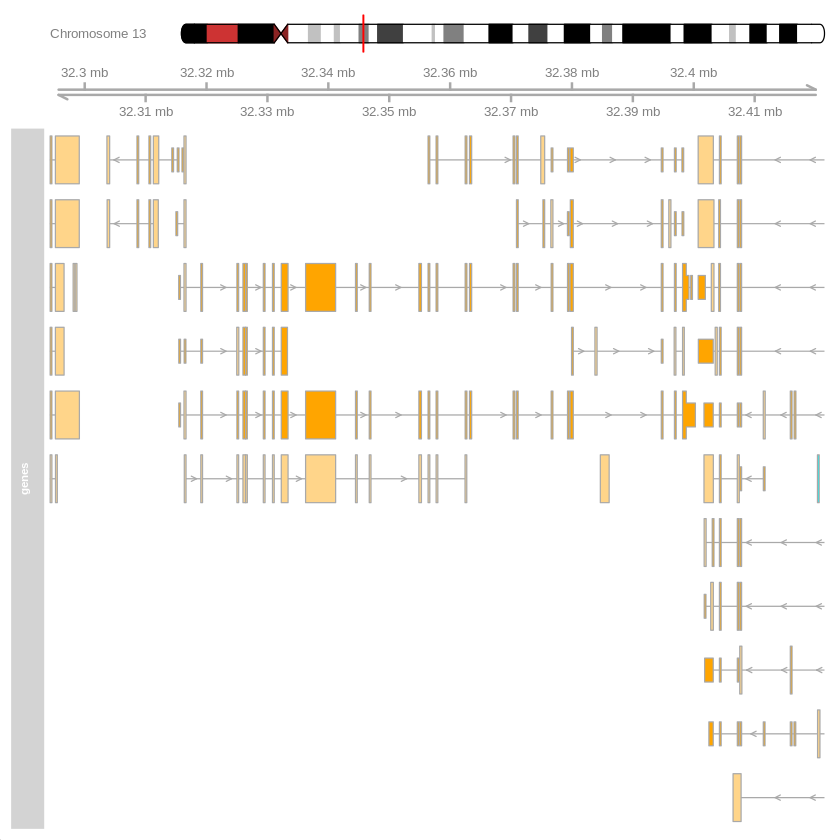

In [ ]:
library(biomaRt)
library(Gviz)
library(GenomicRanges)
ensembl = useMart( host="aug2020.archive.ensembl.org",   
           biomart='ENSEMBL_MART_ENSEMBL'    ,
           dataset='hsapiens_gene_ensembl'   )
itrack  = IdeogramTrack(chromosome=13, "hg38")
gtrack  = GenomeAxisTrack()
getrack = BiomartGeneRegionTrack(start   = 32294275,
                                 end     = 32421464, 
                                 biomart = ensembl, 
                                 chrom   = "chr13",  
                                 genome  = "hg38", 
                                 name    = "genes")

plotTracks(list(itrack,gtrack,getrack),type="l",from=32294275,to=32421464)

In [ ]:
#- track of (merged) conserved elements
ele.rng  = GRanges("chr13",IRanges(pc$most.conserved$start,pc$most.conserved$end))
ee       = reduce(ele.rng,min.gapwidth=5)
pc_track = AnnotationTrack(ee, name = "phastCons_elements",ucscChromosomeNames=FALSE)

coords         = pp_conacc$coord
#ppcon_track    = DataTrack(data=pp_con$score[-length(coords)],chrom="chr13",
#                           start=coords[-length(coords)],
#                           end=coords[-1],genome="hg38",name="phyloP-CON")
ppconacc_track = DataTrack(data=pp_conacc$score[-length(coords)],chrom="chr13",
                           start=coords[-length(coords)],
                           end=coords[-1],genome="hg38",name="phyloP-CONACC")
#ppacchg_track  = DataTrack(data=pp_acchg$score[-length(coords)],chrom="chr13",
#                           start=coords[-length(coords)],
#                           end=coords[-1],genome="hg38",name="phyloP-HGACC")

png 
  2

[1] TRUE

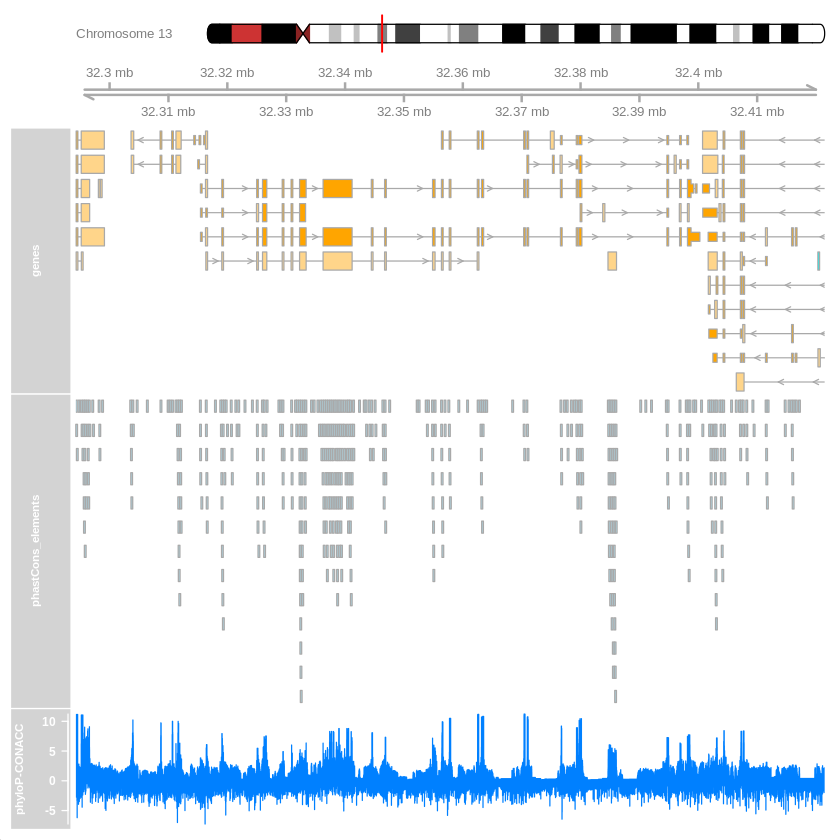

In [ ]:
plotTracks(list(itrack,gtrack,getrack,
#ppcon_track,
pc_track,
ppconacc_track#,
#ppacchg_track
),type=c("l"),from=32294275,to=32421464)

pdf("./region-plot.pdf",width=16,height=6)
plotTracks(list(itrack,gtrack,getrack,
#ppcon_track,
pc_track,
ppconacc_track#,
#ppacchg_track
),
type=c("l"),from=32294275,to=32421464)
dev.off()
Biobase::openPDF("./region-plot.pdf")